# Titanic: Machine Learning from Disaster - Simplified version

## Getting Started Prediction Competition

### Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [127]:
from IPython.display import display, HTML
HTML('<iframe width="1000" height="515" src="https://www.youtube.com/embed/9xoqXVjBEF8" frameborder="0" allowfullscreen></iframe>')

### Evaluation

#### Goal
Predict if a passenger survived the sinking of the Titanic or not. 

#### Metric
Your score is the percentage of passengers you correctly predict. This is known simply as "accuracy”.

***

### Data Exploration

**Keyword:** summary, correclation, data type.

The goal here is to explore the data, understand the distribution and relation of the differents features.


In [128]:
# data analysis and wrangling
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.style.use('fivethirtyeight')

# Data preparation
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute

# Modeling 
from __future__ import division
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
#import xgboost as xgb

In [129]:
##Directory
#import os 
#print(os.getcwd())

In [130]:
#%% load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Data Dictionary

survival: Survival -> 0 = No, 1 = Yes  
pclass: Ticket class -> 1 = 1st, 2 = 2nd, 3 = 3rd (Lower)  
sex.	
Age. (if less than 1 then = xx.5)  
sibsp: of siblings (brother, sister, stepbrother, stepsister) and spouse.	  
parch: of parents (mother, father) and daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore parch=0 for them.  
ticket: Ticket number  
fare: Passenger fare	 
cabin: Cabin number	  
embarked: Port of Embarkation -> C = Cherbourg, Q = Queenstown, S = Southampton  

#### Data type:   

Categorical:
- Name, Ticket  

Discrete
- Binary: Survived, Sex   
- Ordinal: Pclass, Cabin    
- Nominal: Embarked, SibSp, Parch   

Continuious (Numeric)  
- Age, Fare, PassengerId   


***

## Data Preparation

**Keyword:** feature selection, feature extraction, missing values, outliers.

The goal here is to select the most relevant features, reshape them, handle missing values and outliers and get data ready to be processed by different machine learning models.


In [131]:
def ingest_data():
    train = pd.read_csv('train.csv').assign(Train = 1)
    test = (pd.read_csv('test.csv').assign(Train = 0)
            .assign(Survived = -999)[list(train)])
    return pd.concat([train, test])

extract_lastname = lambda x: x.split(',')[0]
data = ingest_data()
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Train
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


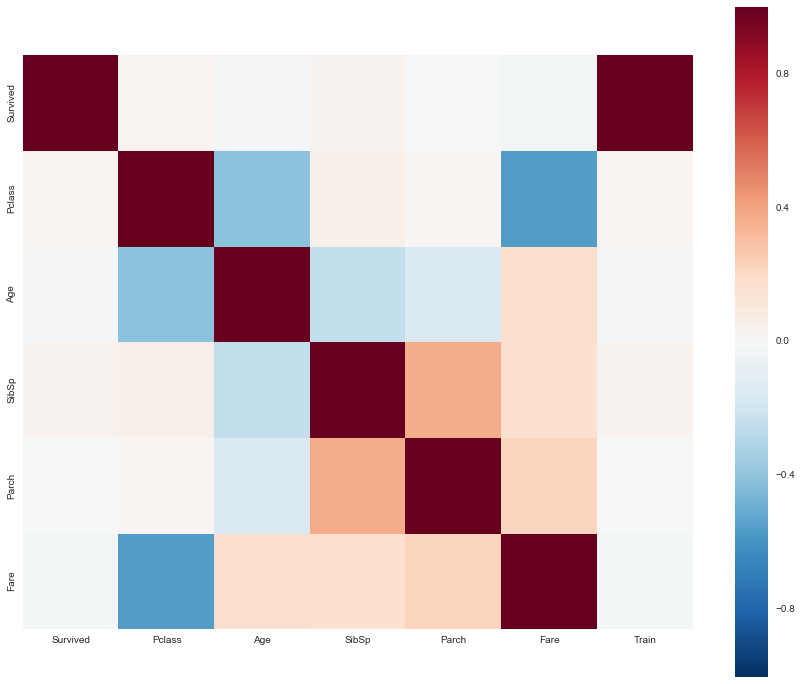

In [132]:
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr().drop(['Train'])
plt.figure(figsize=(15, 12))
sns.heatmap(corr, vmax=1, square=True)

In [133]:
# fill embarked with the most occured value
data['Embarked'] = data['Embarked'].fillna('S')

In [134]:
# Sources code: https://github.com/jakesherman/titanic-kaggle/blob/master/data-processing-modeling.ipynb 

def extract_title(x):
    """Get the person's title from their name. Combine reduntant or less common 
    titles together.
    """
    title = x.split(',')[1].split('.')[0][1:]
    if title in ['Mlle', 'Ms']:
        title = 'Miss'
    elif title == 'Mme':
        title = 'Mrs'
    elif title in ['Rev', 'Dr', 'Major', 'Col', 'Capt', 'Jonkheer', 'Dona']:
        title = 'Esteemed'
    elif title in ['Don', 'Lady', 'Sir', 'the Countess']:
        title = 'Royalty'
    return title

first_letter = np.vectorize(lambda x: x[:1]) 

In [135]:
def sex_numeric(x):
    """ Transform sex to a numeric variable
    """
    if x in ['male']:
        x = '1'
    elif x in ['female']:
        x = '0'
    return x


In [136]:
def create_dummy_nans(data, col_name):
    """Create dummies for a column in a DataFrame, and preserve np.nans in their 
    original places instead of in a separate _nan column.
    """
    deck_cols = [col for col in list(data) if col_name in col]
    for deck_col in deck_cols:
        data[deck_col] = np.where(
            data[col_name + 'nan'] == 1.0, np.nan, data[deck_col])
    return data.drop([col_name + 'nan'], axis = 1)


In [137]:
def feature_engineering(data):
    return (data
            # Create last name, title, family size, and family features
            .assign(LastName = lambda x: x.Name.map(extract_lastname))
            .assign(Title = lambda x: x.Name.map(extract_title))
            .assign(FamSize = lambda x: x.SibSp + x.Parch + 1)
            .assign(Family = lambda x: [a + '_' + str(b) for a, b in zip(
                    list(x.LastName), list(x.FamSize))])

            .assign(Sex = lambda x: x.Sex.map(sex_numeric))
            
             # Turn the Cabin feature into a Deck feature (A-G)
            .assign(Deck = lambda x: np.where(
            pd.notnull(x.Cabin), first_letter(x.Cabin.fillna('z')), x.Cabin))
            .assign(Deck = lambda x: np.where(x.Deck == 'T', np.nan, x.Deck))
            
            # Create dummy variables for the categorical features
            .assign(Pclass = lambda x: x.Pclass.astype(str))
            .pipe(pd.get_dummies, columns = ['Pclass','Title']) # Can add 'Family' and even'Ticket'.
            .pipe(pd.get_dummies, columns = ['Embarked'], dummy_na = True)
            .pipe(create_dummy_nans, 'Embarked_')
            
            # Drop columns we don't need
            .drop(['Name', 'Cabin', 'Ticket', 'PassengerId', 'SibSp', 'Parch'], axis = 1)
            
    )

In [138]:
data = feature_engineering(data)

In [139]:
data.head()

,Survived,Sex,Age,Fare,Train,LastName,FamSize,Family,Deck,Pclass_1,...,Pclass_3,Title_Esteemed,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,7.2500,1,Braund,2,Braund_2,NaN,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0,38.0,71.2833,1,Cumings,2,Cumings_2,C,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0,26.0,7.9250,1,Heikkinen,1,Heikkinen_1,NaN,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,35.0,53.1000,1,Futrelle,2,Futrelle_2,C,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,1,35.0,8.0500,1,Allen,1,Allen_1,NaN,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


#### Impute missing values

In [140]:
def impute(data):
    """Impute missing values in the Age, Embarked, and Fare features.
    """
    impute_missing = data.drop(['Survived', 'Train', 'LastName', 'Deck', 'Family'], axis = 1)
    impute_missing_cols = list(impute_missing)

    #filled_soft = fancyimpute.MICE().complete(np.array(impute_missing))
    X_filled_knn = KNN(k=5).complete(impute_missing)
    results = pd.DataFrame(X_filled_knn, columns = impute_missing_cols)
    results['Train'] = list(data['Train'])
    results['Survived'] = list(data['Survived'])
    results['LastName'] = list(data['LastName'])
    results['Deck'] = list(data['Deck'])

    #assert results.isnull().sum().sum() == 0, 'Not all NAs removed'
    return results

In [141]:
data = impute(data)

Imputing row 1/1309 with 0 missing, elapsed time: 0.376
Imputing row 101/1309 with 0 missing, elapsed time: 0.377
Imputing row 201/1309 with 0 missing, elapsed time: 0.377
Imputing row 301/1309 with 1 missing, elapsed time: 0.378
Imputing row 401/1309 with 0 missing, elapsed time: 0.379
Imputing row 501/1309 with 0 missing, elapsed time: 0.379
Imputing row 601/1309 with 0 missing, elapsed time: 0.380
Imputing row 701/1309 with 0 missing, elapsed time: 0.381
Imputing row 801/1309 with 0 missing, elapsed time: 0.382
Imputing row 901/1309 with 0 missing, elapsed time: 0.383
Imputing row 1001/1309 with 0 missing, elapsed time: 0.383
Imputing row 1101/1309 with 0 missing, elapsed time: 0.384
Imputing row 1201/1309 with 0 missing, elapsed time: 0.385
Imputing row 1301/1309 with 0 missing, elapsed time: 0.386


#### Transform numerical variables

In [142]:
data['FareBand'] = pd.qcut(data['Fare'], 4)

def Fare(x):
    """ Transform sex to a numeric variable
    """
    if x in ['[0, 7.896]']:
        x = '0'
    elif x in ['(7.896, 14.454]']:
        x = '1'
    elif x in ['(14.454, 31.275]']:
        x = '2'
    elif x in ['(31.275, 512.329]']:
        x = '3'
    return x

In [143]:
data['Agecut'] = pd.qcut(data['Age'], 4)

def Age(x):
    """ Transform sex to a numeric variable
    """
    if x in ['[0.17, 21.134]']:
        x = '0'
    elif x in ['(21.134, 28.8]']:
        x = '1'
    elif x in ['(28.8, 38.5]']:
        x = '2'
    elif x in ['(38.5, 80]']:
        x = '3'
    return x

In [144]:
def feature_engineering_test(data):
    return (data
        .assign(FareBand = lambda x: x.FareBand.map(Fare))
        .assign(Agecut = lambda x: x.Agecut.map(Age))
            
         # Drop columns we don't need
        .drop(['Fare', 'Age', 'LastName', 'Deck'], axis = 1) #We could use Deck!
            
    )

In [145]:
data = feature_engineering_test(data)
data.head()

,Sex,FamSize,Pclass_1,Pclass_2,Pclass_3,Title_Esteemed,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Train,Survived,FareBand,Agecut
0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0,0,1
1,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1,3,2
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1
3,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,3,2
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0,1,2


## Modeling

The goal here is to predict if a passenger survived the sinking of the Titanic or not. 

In [146]:
def split_data(data):
    """
    Split the combined training/prediction data into separate training and 
    prediction sets.
    """
    outcomes = np.array(data.query('Train == 1')['Survived'])
    train = (data.query('Train == 1')
             .drop(['Train', 'Survived'], axis = 1))
    to_predict = (data.query('Train == 0')
                  .drop(['Train', 'Survived'], axis = 1))
    return train, outcomes, to_predict

## OR
#X_train = train_df.drop("Survived", axis=1)
#Y_train = train_df["Survived"]
#X_test  = test_df.drop("PassengerId", axis=1).copy()
#X_train.shape, Y_train.shape, X_test.shape

In [147]:
train, outcomes, to_predict = split_data(data)

In [148]:
train.info()
print('_'*40)
to_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 16 columns):
Sex               891 non-null float64
FamSize           891 non-null float64
Pclass_1          891 non-null float64
Pclass_2          891 non-null float64
Pclass_3          891 non-null float64
Title_Esteemed    891 non-null float64
Title_Master      891 non-null float64
Title_Miss        891 non-null float64
Title_Mr          891 non-null float64
Title_Mrs         891 non-null float64
Title_Royalty     891 non-null float64
Embarked_C        891 non-null float64
Embarked_Q        891 non-null float64
Embarked_S        891 non-null float64
FareBand          891 non-null category
Agecut            891 non-null category
dtypes: category(2), float64(14)
memory usage: 106.2 KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 16 columns):
Sex               418 non-null float64
FamSize           418 non

In [149]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(train, outcomes)
Y_pred = logreg.predict(to_predict)
acc_log = round(logreg.score(train, outcomes) * 100, 2)
acc_log

83.390000000000001

In [150]:
# Support Vector Machines
svc = SVC()
svc.fit(train, outcomes)
Y_pred = svc.predict(to_predict)
acc_svc = round(svc.score(train, outcomes) * 100, 2)
acc_svc

83.609999999999999

In [151]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train, outcomes)
Y_pred = knn.predict(to_predict)
acc_knn = round(knn.score(train, outcomes) * 100, 2)
acc_knn

85.969999999999999

In [152]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(train, outcomes)
Y_pred = gaussian.predict(to_predict)
acc_gaussian = round(gaussian.score(train, outcomes) * 100, 2)
acc_gaussian

80.469999999999999

In [153]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(train, outcomes)
Y_pred = perceptron.predict(to_predict)
acc_perceptron = round(perceptron.score(train, outcomes) * 100, 2)
acc_perceptron

77.549999999999997

In [154]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(train, outcomes)
Y_pred = linear_svc.predict(to_predict)
acc_linear_svc = round(linear_svc.score(train, outcomes) * 100, 2)
acc_linear_svc

83.609999999999999

In [155]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, outcomes)
Y_pred = decision_tree.predict(to_predict)
acc_decision_tree = round(decision_tree.score(train, outcomes) * 100, 2)
acc_decision_tree

88.659999999999997

In [156]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train, outcomes)
Y_pred = random_forest.predict(to_predict)
random_forest.score(train, outcomes)
acc_random_forest = round(random_forest.score(train, outcomes) * 100, 2)
acc_random_forest

88.659999999999997

#### Ensemble methods
_Combine Model Predictions Into Ensemble Predictions_  

The three most popular methods for combining the predictions from different models are:  

- Bagging. Building multiple models (typically of the same type) from different subsamples of the training dataset.  
- Boosting. Building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the chain.  
- Voting. Building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions.  

*http://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/ 

In [ ]:
def majority_vote_ensemble(name, models_votes, train, outcomes, to_predict):
    """Creates a submission from a majority voting ensemble, given training/
    testing data and a list of models and votes.
    """
    model_results = []
    for model, votes in models_votes:
        model.fit(np.array(train), outcomes)
        probs = model.predict(np.array(to_predict))
        probs[probs == 0] = -1
        model_results.append((probs, votes))
    
    # Assemble the ensemble
    ensemble = pd.read_csv('data/test.csv')[['PassengerId']].assign(Survived = 0)
    for probs, votes in model_results:
        for i in range(0, votes):
            ensemble = ensemble.assign(Survived = lambda x: x.Survived + probs)
    (ensemble.assign(Survived = lambda x: np.where(x.Survived > 0, 1, 0))
     .to_csv(name, index = False))
    return None
    
    
models_votes = [
    (random_forest.best_estimator_, 2),
    (decision_tree.best_estimator_, 1)
]


majority_vote_ensemble('submissions/ensemble_majority_vote.csv', 
                       models_votes, train, outcomes, to_predict)